In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

# Workflow 

1. read in buffer_30000m_cbg
2. read in fires_LA_2020
3. Calculate distance to nearest fire for each CBG
4. read in POIs
5. Calculate number of POIs in every CBG
6. read CBG Census data 
7. Add population data to CBG 

In [5]:
# read CBG 30000m 
#ca_cbg = gpd.read_file('C:/Users/noibar/Downloads/tl_2019_06_bg/tl_2019_06_bg.shp')
ca_cbg = gpd.read_file('C:/Users/noibar/YandexDisk/ucsb/ucsb_summer2022/RMP/la_fire_cbg_30000m.geojson')
print(ca_cbg.shape)
print(ca_cbg.crs)

(7822, 13)
epsg:4269


In [6]:
# read fires
fires = gpd.read_file('C:/Users/noibar/YandexDisk/ucsb/ucsb_summer2022/RMP/la_fires_2020_3857.geojson') 
print(fires.shape)
print(fires.crs)

(16, 19)
epsg:3857


In [7]:
# reproject cbg
ca_cbg = ca_cbg.to_crs('epsg: 3857')
print(ca_cbg.crs)

epsg: 3857


In [8]:
ca_cbg['dist_to_fire_m'] = ca_cbg.geometry.apply(lambda x: fires.distance(x).min()) 

In [9]:
ca_cbg.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,dist_to_fire_m
0,06,111,007506,5,061110075065,Block Group 5,G5030,S,469020,15988,+34.2526098,-118.7395930,"MULTIPOLYGON (((-13218628.981 4063392.660, -13...",24424.649639
1,06,065,030104,2,060650301042,Block Group 2,G5030,S,858394,0,+33.9993465,-117.3660904,"MULTIPOLYGON (((-13066242.518 4029094.346, -13...",28728.512410
2,06,065,031501,5,060650315015,Block Group 5,G5030,S,233796,0,+33.9331513,-117.4280261,"MULTIPOLYGON (((-13072432.900 4019792.884, -13...",19578.931466
3,06,111,007512,2,061110075122,Block Group 2,G5030,S,925075,51577,+34.2580996,-118.7381322,"MULTIPOLYGON (((-13218508.644 4063782.041, -13...",23505.369679
4,06,037,187200,2,060371872002,Block Group 2,G5030,S,543859,8150,+34.1069009,-118.2493596,"MULTIPOLYGON (((-13164313.054 4043275.918, -13...",24565.305778


In [11]:
# read POI data 
poi1 = pd.read_csv('C:/Users/noibar/Downloads/ca_poi_nov20_now.gzip', compression='gzip')
print(poi1.shape)
poi2 = pd.read_csv('C:/Users/noibar/Downloads/ca_poi_pre_nov20.gzip', compression='gzip')
print(poi2.shape)

c:\Users\noibar\anaconda3\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1877453, 13)
(1877453, 13)


In [13]:
# drop duplicates based on col subsets
cols_to_drop = [
    'placekey', 
    'location_name', 
    'latitude', 
    'longitude'
]

In [15]:
poi = pd.concat([poi1, poi2])
print(poi.shape)

(3754906, 13)


In [16]:
poi = poi.drop_duplicates(subset=cols_to_drop)
print(poi.shape)

(1825204, 13)


In [22]:
# first cut filter out by bbox
# bounds: Polygon ((-119.472754 32.528832, -114.450152 32.528832, -114.450152 35.218627, -119.472754 35.218627, -119.472754 32.528832))
poi = poi.loc[(poi.longitude<=-114.45015)&(poi.longitude>=-119.472754)&(poi.latitude>=-32.528832)&(poi.longitude<=-35.218627)]
print(poi.shape)

# convert POI to spatial file 
geom = gpd.points_from_xy(poi.longitude, poi.latitude, crs="epsg:4326")
geo_poi = gpd.GeoDataFrame(poi, geometry=geom)
geo_poi.to_crs('epsg:3857', inplace=True)
print(geo_poi.crs)

(1084735, 13)
epsg:3857


In [26]:
ca_cbg.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,dist_to_fire_m
0,06,111,007506,5,061110075065,Block Group 5,G5030,S,469020,15988,+34.2526098,-118.7395930,"MULTIPOLYGON (((-13218628.981 4063392.660, -13...",24424.649639
1,06,065,030104,2,060650301042,Block Group 2,G5030,S,858394,0,+33.9993465,-117.3660904,"MULTIPOLYGON (((-13066242.518 4029094.346, -13...",28728.512410
2,06,065,031501,5,060650315015,Block Group 5,G5030,S,233796,0,+33.9331513,-117.4280261,"MULTIPOLYGON (((-13072432.900 4019792.884, -13...",19578.931466
3,06,111,007512,2,061110075122,Block Group 2,G5030,S,925075,51577,+34.2580996,-118.7381322,"MULTIPOLYGON (((-13218508.644 4063782.041, -13...",23505.369679
4,06,037,187200,2,060371872002,Block Group 2,G5030,S,543859,8150,+34.1069009,-118.2493596,"MULTIPOLYGON (((-13164313.054 4043275.918, -13...",24565.305778


In [31]:
# first keep only POIs within CBGs 
clipped_poi = gpd.sjoin(ca_cbg, geo_poi, predicate='contains', how='left')
print(clipped_poi.shape)

(645103, 28)


In [32]:
clipped_poi.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,sub_category,naics_code,latitude,longitude,city,region,postal_code,iso_country_code,opened_on,closed_on
0,06,111,007506,5,061110075065,Block Group 5,G5030,S,469020,15988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06,065,030104,2,060650301042,Block Group 2,G5030,S,858394,0,...,NaN,3399.0,34.001717,-117.371553,Riverside,CA,92501.0,US,NaN,NaN
1,06,065,030104,2,060650301042,Block Group 2,G5030,S,858394,0,...,Motor Vehicle Towing,488410.0,33.996827,-117.363904,Riverside,CA,92501.0,US,NaN,NaN
1,06,065,030104,2,060650301042,Block Group 2,G5030,S,858394,0,...,NaN,3399.0,34.000437,-117.370594,Riverside,CA,92501.0,US,NaN,NaN
1,06,065,030104,2,060650301042,Block Group 2,G5030,S,858394,0,...,Offices of Physicians (except Mental Health Sp...,621111.0,34.000850,-117.371483,Riverside,CA,92501.0,US,NaN,NaN


In [33]:
clipped_poi.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry', 'dist_to_fire_m', 'index_right', 'placekey',
       'location_name', 'top_category', 'sub_category', 'naics_code',
       'latitude', 'longitude', 'city', 'region', 'postal_code',
       'iso_country_code', 'opened_on', 'closed_on'],
      dtype='object')

In [34]:
gg = clipped_poi.groupby('GEOID')['placekey'].size().reset_index()

gg.head()

,GEOID,placekey
0,060290033051,51
1,060290033052,81
2,060290033053,35
3,060290033061,185
4,060290055061,62


In [37]:
gg.columns = ['GEOID', 'poi_cnt']

In [38]:
# join the gg back to CBGs
ca_cbg_poi = pd.merge(ca_cbg, gg, how='left')
print(ca_cbg_poi.shape)
ca_cbg_poi.head()

(7822, 15)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,dist_to_fire_m,poi_cnt
0,06,111,007506,5,061110075065,Block Group 5,G5030,S,469020,15988,+34.2526098,-118.7395930,"MULTIPOLYGON (((-13218628.981 4063392.660, -13...",24424.649639,1
1,06,065,030104,2,060650301042,Block Group 2,G5030,S,858394,0,+33.9993465,-117.3660904,"MULTIPOLYGON (((-13066242.518 4029094.346, -13...",28728.512410,95
2,06,065,031501,5,060650315015,Block Group 5,G5030,S,233796,0,+33.9331513,-117.4280261,"MULTIPOLYGON (((-13072432.900 4019792.884, -13...",19578.931466,12
3,06,111,007512,2,061110075122,Block Group 2,G5030,S,925075,51577,+34.2580996,-118.7381322,"MULTIPOLYGON (((-13218508.644 4063782.041, -13...",23505.369679,9
4,06,037,187200,2,060371872002,Block Group 2,G5030,S,543859,8150,+34.1069009,-118.2493596,"MULTIPOLYGON (((-13164313.054 4043275.918, -13...",24565.305778,68


<AxesSubplot:ylabel='Frequency'>

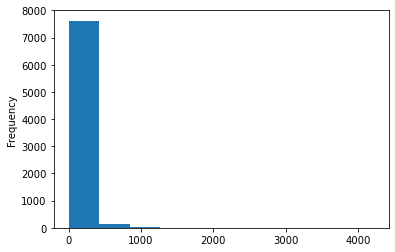

In [40]:
ca_cbg_poi.poi_cnt.plot(kind='hist')